# Train RBM on pandemic sequences + prepandemic sequences

In [1]:
import os, sys
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
pgm_path = 'PGM/'
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')
import rbm, RBM_utils
import utilities, Proteins_utils, sequence_logo, plots_utils 
from global_variables import *
%matplotlib inline

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score
import numpy as np
import os
import re
import matplotlib as mpl
from collections import Counter


e:\ESCAPE_MAP_DRAFT\PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
e:\ESCAPE_MAP_DRAFT\PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


In [2]:
path = 'seq_data/'
filename = 'rbd_aligned_sequences.fasta'

In [3]:
sequences = Proteins_utils.load_FASTA(path + filename) # Load protein sequences.
print('shape of sequences:', np.shape(sequences))
print('sequences:', sequences)
sequences=np.array(sequences)

shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]


In [4]:
WT_SEQ.shape

(178,)

In [6]:

train_sequences=np.vstack([WT_SEQ, sequences])
print('Train sequences shape:', train_sequences.shape)


Train sequences shape: (2241, 178)


## Add pandemic sequences

In [ ]:
# --- user/config ---
FASTA = "seq_data/ns_mutated_spike_100k.fasta"   # numeric-encoded FASTA expected by Proteins_utils.load_FASTA
PCTS = [0.05, 0.10, 0.50, 1]

SEED  = 123
N_ITER = 50
N_HIDDEN = 100
L1B = 0.12
N_MC = 10

def get_base_sequences_like(ref_array):
    """
    Use existing 'sequences' from the outer scope if defined.
    Else return an empty array with matching width and dtype.
    """
    try:
        base = sequences  # noqa: F821
        assert isinstance(base, np.ndarray)
        assert base.shape[1] == ref_array.shape[1]
        return base
    except Exception:
        return np.empty((0, ref_array.shape[1]), dtype=ref_array.dtype)

# --- load numeric sequences present "before" ---
ALLVOCS_NUM_before = Proteins_utils.load_FASTA(FASTA, drop_duplicates=True)
print("ALLVOCS_NUM_before shape:", ALLVOCS_NUM_before.shape)

# base set to merge with (if not provided by caller, this is empty)
BASE_SEQ = Proteins_utils.load_FASTA("seq_data/rbd_aligned_sequences.fasta")
print("Base set shape:", BASE_SEQ.shape)

# RNG
rng = np.random.default_rng(SEED)

# ensure output dir
os.makedirs("rbm_models", exist_ok=True)

for pct in PCTS:
    # sample pct of ALLVOCS_NUM_before without replacement
    n_total = BASE_SEQ.shape[0]
    n_keep = max(1, int(round(pct * n_total)))
    idx = rng.choice(n_total, size=n_keep, replace=False)
    VOCS_NUM_before = ALLVOCS_NUM_before[idx]
    print(f"[{int(pct*100)}%] sampled before-set shape:", VOCS_NUM_before.shape)

    # merge with base sequences
    merged_seq = np.concatenate([VOCS_NUM_before, BASE_SEQ], axis=0)
    print(f"[{int(pct*100)}%] merged shape:", merged_seq.shape)

    # weights: all ones 
    sequence_weights = np.ones(merged_seq.shape[0], dtype=np.float32)


    # build and fit RBM
    RBM_P = rbm.RBM(
        visible='Potts',
        hidden='dReLU',
        n_v=merged_seq.shape[-1],
        n_cv=21,
        n_h=N_HIDDEN
    )

    RBM_P.fit(
        merged_seq,
        weights=sequence_weights,
        n_iter=N_ITER,
        N_MC=N_MC,
        verbose=1,
        vverbose=1,
        l1b=L1B
    )

    # save with descriptive name
    save_name = f"rbm_models/RBM_pandemic_{int(pct*100)}.data"
    RBM_utils.saveRBM(save_name, RBM_P)
    # report mean likelihood
    try:
        ll = RBM_P.likelihood(merged_seq).mean()
        print(f"[{int(pct*100)}%] mean likelihood: {ll:.4f}")
    except Exception as e:
        print(f"[{int(pct*100)}%] likelihood eval skipped: {e}")


ALLVOCS_NUM_before shape: (3704, 178)
Base set shape: (2240, 178)
[5%] sampled before-set shape: (112, 178)
[5%] merged shape: (2352, 178)
Iteration number 0, pseudo-likelihood: -1.05
Starting epoch 1
[RBM] Iteration 1, time = 1.51s, pseudo-likelihood = -1.93
Starting epoch 2
[RBM] Iteration 2, time = 1.51s, pseudo-likelihood = -3.25
Starting epoch 3


e:\ESCAPE_MAP_DRAFT\PGM/source\layer.py:1188: RuntimeWarning: overflow encountered in divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)
e:\ESCAPE_MAP_DRAFT\PGM/source\layer.py:1225: RuntimeWarning: overflow encountered in divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)


[RBM] Iteration 3, time = 1.48s, pseudo-likelihood = -4.23
Starting epoch 4
[RBM] Iteration 4, time = 1.33s, pseudo-likelihood = -6.21
Starting epoch 5
[RBM] Iteration 5, time = 1.39s, pseudo-likelihood = -6.06
Starting epoch 6
[RBM] Iteration 6, time = 1.40s, pseudo-likelihood = -6.09
Starting epoch 7
[RBM] Iteration 7, time = 1.34s, pseudo-likelihood = -6.52
Starting epoch 8
[RBM] Iteration 8, time = 1.37s, pseudo-likelihood = -5.36
Starting epoch 9
[RBM] Iteration 9, time = 1.37s, pseudo-likelihood = -3.28
Starting epoch 10
[RBM] Iteration 10, time = 1.40s, pseudo-likelihood = -3.72
Starting epoch 11
[RBM] Iteration 11, time = 1.34s, pseudo-likelihood = -4.30
Starting epoch 12
[RBM] Iteration 12, time = 1.41s, pseudo-likelihood = -2.78
Starting epoch 13
[RBM] Iteration 13, time = 1.35s, pseudo-likelihood = -1.84
Starting epoch 14
[RBM] Iteration 14, time = 1.38s, pseudo-likelihood = -0.60
Starting epoch 15
[RBM] Iteration 15, time = 1.40s, pseudo-likelihood = -0.41
Starting epoch 16

# Application to df bloom

# protein Expression

In [9]:
df_bloom=pd.read_csv('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.csv')
df_bloom=df_bloom[df_bloom['site_SARS2']>=349] 
df_bloom=df_bloom[df_bloom['site_SARS2']<=526]
#reset index
df_bloom=df_bloom.reset_index(drop=True)
#sequence column to fasta file
with open('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta', 'w') as f:
    for index, row in df_bloom.iterrows():
        #if * in sequence, remove sequence
        if '*' in row['sequence']:
            continue
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')


In [10]:
bloom_sequences=Proteins_utils.load_FASTA('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta')
print('shape of sequences:', np.shape(bloom_sequences))
bloom_sequences = [seq[BEGIN:-END] for seq in bloom_sequences]
bloom_sequences=np.array(bloom_sequences)
# bloom_sequences=one_hot_encode_matrix(bloom_sequences)
bloom_sequences.shape

shape of sequences: (3327, 201)


(3327, 178)

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


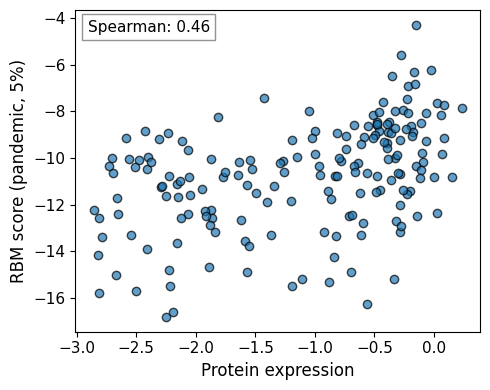

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


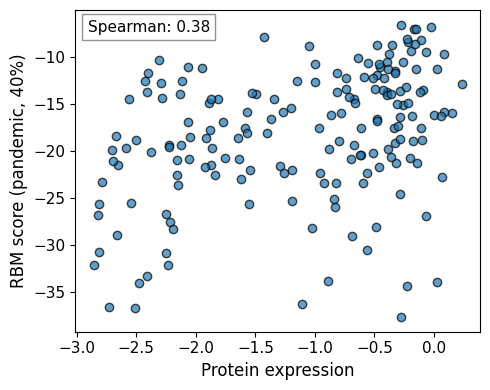

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


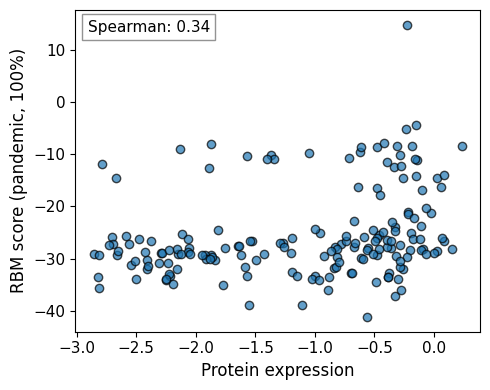

In [ ]:

PCTS = [5, 40, 100]

WT_embe = Proteins_utils.load_FASTA('seq_data/rbd_wt.fasta')
WT_embe = np.array([seq[BEGIN:-END] for seq in WT_embe])

for pct in PCTS:
    rbm_path = f"rbm_models/RBM_pandemic_{pct}.data"
    RBM_P = RBM_utils.loadRBM(rbm_path)

    # likelihoods
    df_bloom = df_bloom.copy()
    sequences_likelihood = RBM_P.likelihood(bloom_sequences)
    df_bloom["likelihood"] = np.where(np.isnan(sequences_likelihood), -300.0, sequences_likelihood)

    likelihood_WT = float(RBM_P.likelihood(WT_embe)[0])

    # delta E and site-level average
    df_bloom["deltaE"] = -likelihood_WT + df_bloom["likelihood"]
    df_bloom_avg = (df_bloom
                    .groupby("site_SARS2", as_index=False)
                    .agg(expr_avg=("expr_avg", "mean"),
                         deltaE=("deltaE", "mean")))

    # stats
    spearman_corr, spearman_pval = stats.spearmanr(df_bloom_avg["expr_avg"], df_bloom_avg["deltaE"])
    r2 = r2_score(df_bloom_avg["expr_avg"], df_bloom_avg["deltaE"])

    # plot
    plt.figure(figsize=(5, 4))
    plt.scatter(df_bloom_avg["expr_avg"], df_bloom_avg["deltaE"],
                alpha=0.7, edgecolor="black")

    plt.xlabel("Protein expression", fontsize=12)
    plt.ylabel(f"RBM score (pandemic, {pct}%)", fontsize=12)

    textstr = f"Spearman: {spearman_corr:.2f}"
    plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes,
             fontsize=11, va="top", bbox=dict(facecolor="white", alpha=0.85, edgecolor="grey"))

    ax = plt.gca()
    ax.tick_params(labelsize=11)


    plt.tight_layout()
    plt.show()
